# Text Classifier

## Introduction

In this coursework, we explore the implementation of a text classifier for sentiment analysis, particularly in the context of the film industry. The rapid expansion of social media and online review platforms has made gauging a movie's quality more challenging. With a wide range of film preferences among audiences, it becomes difficult to judge the merit of new movie releases, often leading to a fear of missing out (FOMO) among viewers.

Additionally, considering the rising costs of living, choosing to spend on a cinema experience is a significant decision. The disappointment of watching an unsatisfactory film after spending money can be quite disheartening.

In response to these challenges, we suggest creating an advanced text classification tool. This solution is designed to leverage sentiment analysis for interpreting movie reviews. The goal is to provide a more balanced and financially savvy way to assess films.

### Goals

This report addresses the challenge of developing a text classifier capable of discerning the general sentiment in movie reviews.

Therefore, the primary aim is to:

To accurately categorize movie reviews with positive or negative tags.


### Data Source


- **Dataset**: Large Movie Review Dataset
- **Source**: Stanford AI Lab
- **URL**: [https://ai.stanford.edu/~amaas/data/sentiment/](https://ai.stanford.edu/~amaas/data/sentiment/)
- **Reference Paper**: "Learning Word Vectors for Sentiment Analysis"
- **Authors**: Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, Christopher Potts
- **Paper URL**: [https://aclanthology.org/P11-1015/](https://aclanthology.org/P11-1015/)
- **Conference**: ACL 2011


This comprehensive dataset encompasses an extensive array of movie reviews, specifically designed for binary sentiment analysis tasks.

The dataset contains 100,000 movie reviews in total.. The collection is split into two groups: 25,000 reviews for training and another 25,000 for testing, along with 50,000 unlabelled reviews intended for unsupervised learning methods.

As our text classifier's primary goal is to assign binary labels (positive or negative) to each review, this analysis will focus exclusively on the labelled reviews, in line with the supervised nature of our task.

The dataset is organized into two principal directories, one each for the labelled training and testing sets. Within these, there are further subdivisions into two categories: one for positive reviews and the other for negative reviews.

**File Naming Convention:**

Each movie review is stored in a text file (.txt). The naming convention used is: "[id]_[rating].txt".

**Rating System Explanation:**

The ratings are derived from IMDB scores. 
- Reviews scoring 4 or lower are labeled as negative.
- Reviews with a score of 7 or higher are marked as positive.
- Reviews with scores of 5 or 6 are not included, as they are considered neutral or unclear in sentiment.

The data collection process involved web scraping from the IMDB website. Each movie review was extracted using its unique ID and corresponding webpage. The dataset also includes URLs for these movies in a urls.txt file, located in the respective test/train folders.

#### Revised Evaluation Approach

In advancing our text classifier's ability to discern movie review sentiments, we employ several pivotal performance metrics:

**Confusion Matrix**
We further utilize the confusion matrix to display the model's predictions against actual values, offering detailed insight into its predictive capabilities.

**F-1 Score**
The F-1 Score harmonizes precision and recall into one metric:
$$ F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall} $$

Our model's emphasis is on a strong recall to ensure comprehensive capture of expressed sentiments. To illustrate, consider the accuracy of the model in classifying truly favorable films.

We also focus on the **F-2 Score**, which gives more weight to recall:
$$ F2 = 5 \times \frac{Precision \times Recall}{(4 \times Precision) + Recall} $$

**Recall**
Also known as sensitivity, this measures how well the model identifies actual positives:
$$ Recall = \frac{True\ Positives}{True\ Positives + False\ Negatives} $$

**Accuracy**
The overall accuracy reflects the proportion of correct predictions made by the model:
$$ Accuracy = \frac{True\ Positives + True\ Negatives}{Total\ Predictions} $$

With an emphasis on the F-2 Score and scrutinizing accuracy and confusion matrix details, we aim to refine sentiment analysis to guide viewers effectively.

**Precision**
This metric gauges the accuracy of positive predictions, calculated as:
$$ Precision = \frac{True\ Positives}{True\ Positives + False\ Positives} $$






## (2) : Implementation

### Data Retrieval

The first step involves processing the  <b>Large Movie Review Dataset</b> which is stored locally on the machine.

In case the required modules are not present in the Python environment, you can install them here in the next cell 

In [ ]:
!pip install nltk
!pip install pandas
!pip install numpy
!pip install gensim
!pip install imbalanced-learn

###  Importing all necessary modules and libraries.

In [1]:
import glob
import numpy as np
import nltk
import re
import glob
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import Word2Vec

# Load necessary modules from sklearn for logistic regression and its functionalities
from sklearn.metrics import precision_score, fbeta_score , recall_score

from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer

from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer



In [2]:
# Download the WordNet corpus
nltk.download('wordnet')

# Download the Open Multilingual WordNet (OMW) corpus
nltk.download('omw')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\j\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to
[nltk_data]     C:\Users\j\AppData\Roaming\nltk_data...
[nltk_data]   Package omw is already up-to-date!


True

In [3]:
# Function parse_reviews - Process each text file in the provided list and compile their contents into a list
def parse_reviews(file_list):
    list_review = [open(file, 'r', encoding='utf-8').read() for file in file_list]
    return list_review

# Function extract_scores_from_filenames - Analyze each file's full path to obtain the numerical score from its filename
# For instance, in the filename "dataset/train/neg\0_3.txt":
# Split using "\\" to isolate '0_3.txt'
# Further split using "_" to separate '0' and '3.txt'
# Finally, split using "." to extract the score '3' from '3.txt'
# The extracted score represents a rating out of 10
def extract_scores_from_filenames(file_list):
    list_of_scores = []

    for file in file_list:
        split_filename = file.split('\\')
        tokens_from_filename = split_filename[1].split('_')
        score_from_filename = tokens_from_filename[1].split('.')

        list_of_scores.append(score_from_filename[0])
        
    return list_of_scores


In [4]:
# Load negative reviews from a specified directory using pandas' read_csv function
negative_reviews_directory = "dataset/train/neg"

# Retrieve all file paths in the negative reviews directory with .txt extension using glob
file_list = glob.glob(negative_reviews_directory + "/*.txt")


### Data Samples View

In [5]:

# Use parse_reviews function to process the files and add their content to a dataframe
list_review = parse_reviews(file_list)

# Use extract_scores_from_filenames function to retrieve film ratings (?/10) and add them to a list and the dataframe
list_of_scores = extract_scores_from_filenames(file_list)

# Label each data entry as negative
negative_reviews = pd.DataFrame({'content_of_the_review': list_review, 'score_of_film': list_of_scores, 'sentiment': "neg"})

# Randomly pick 15 entries from the DataFrame
random_negative_reviews = negative_reviews.sample(15)

# Show the chosen entries
print(random_negative_reviews)


                                   content_of_the_review score_of_film  \
10446  "Don't Drink the Water" is an unbelievably bad...             2   
8886   This mess is so bad it doesn't even qualify as...             2   
2673   The Treasure Island DVD should be required vie...             2   
12008  I'll try to use words to describe this on.... ...             1   
2353   In 1972, after his wife left to go her own way...             4   
8692   (Avast, slight spoilers ahead) I got this tape...             4   
11531  There's no getting around it-- this movie is t...             4   
5947   'Dead Letter Office' is a low-budget film abou...             4   
10926  Well, I guess I'll have to be the one to say "...             4   
12406  When Stanwyck's husband-to-be is murdered on t...             3   
129    I honestly want the last 30 minuets of my life...             1   
498    This is not a film you can really analyse sepa...             4   
9802   This movie is a vehicle for Sch

In [6]:
#  variable naming for positive reviews
positive_reviews_directory = "dataset/train/pos"

file_list = glob.glob(positive_reviews_directory + '/*.txt')

In [7]:
# Parse reviews from the provided list of files
list_review = parse_reviews(file_list)

# Retrieve scores by analyzing filenames in the list
list_of_scores = extract_scores_from_filenames(file_list)

# Create a DataFrame with positive reviews, including content, film scores, and sentiment label
positive_reviews = pd.DataFrame({'content_of_the_review': list_review, 'score_of_film': list_of_scores, 'sentiment': "pos"})

# Randomly choose 15 entries from the DataFrame
random_positive_reviews = positive_reviews.sample(15)

# Output the randomly selected entries
print(random_positive_reviews)


                                   content_of_the_review score_of_film  \
436    Let's cut a long story short. I loved every mi...             9   
7519   I came to watch Guerrilla, part two of Steven ...             8   
2564   There's never a dull moment in this movie. Won...            10   
5976   It's a cooking competition show, Americanized....            10   
1576   Claire Denis' debut is both a brave and self-a...            10   
3000   Excellent political thriller, played much quie...             8   
5189   This movie is a must-see movie for all. Congre...            10   
5484   Greetings again from the darkness. 18 director...             7   
10849  The cast was good, and I thought it was a good...             8   
806    To my surprise I quite enjoyed 'Spacecamp', i ...             7   
6289   <br /><br />In anticipation of Ang Lee's new m...            10   
4437   Remarkable, disturbing film about the true-lif...            10   
931    I spotted this movie in the vid

### Dataframe size comparison

Now we will visualize the size of the data by plotting it.

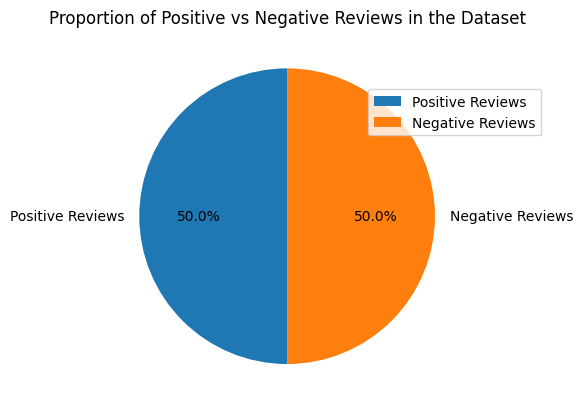

In [8]:
dataplot = pd.DataFrame(
    {"dataset_size": [len(positive_reviews.index), len(negative_reviews.index)]},
        index=["Positive Reviews", "Negative Reviews"])

# Create a pie chart for visualizing the proportions
dataplot.plot(kind="pie", y='dataset_size', autopct='%1.1f%%', startangle=90, legend=True)
plt.title("Proportion of Positive vs Negative Reviews in the Dataset")
plt.ylabel('')  # Removing the y-axis label
plt.legend(loc='lower left', bbox_to_anchor=(0.7, 0.7))
# Show the pie chart on screen
plt.show()


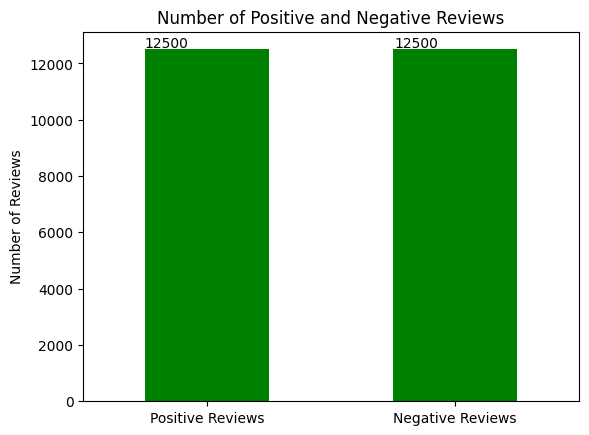

In [9]:
# Plotting a bar chart
ax = dataplot.plot(kind="bar", legend=False, color=['green', 'red'])
plt.title("Number of Positive and Negative Reviews")
plt.ylabel('Number of Reviews')

# Rotating x-axis labels to horizontal
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Adding the text inside the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Display the bar chart
plt.show()

As illustrated in the chart, both the positive and negative review dataframes have an equal count of 12,500 entries, confirming their balanced presence in the dataset.

Having a balanced dataset is crucial as it eliminates any skewness towards any category in our data, ensuring impartiality across all classes.

### Preprocessing

After a thorough analysis of the data frames, I've decided to employ a Continuous Bag of Words (CBoW) model to represent the word patterns within the positive and negative datasets.

This particular model was chosen over the conventional Bag of Words (BoW) approach due to its ability to capture the contextual nuances of language. While BoW views each word as an independent entity, disregarding word order, CBoW acknowledges the importance of word sequence and how it shapes meaning within sentences. This sensitivity to context is essential for achieving accurate results in our binary classification endeavor.

##### Preprocessing Text for Word2Vec Model using Gensim Library

##### Introduction:
From the gensim library the model will use the Word2Vec algorithm for the build of a Continuous Bag of Words representation. 
For optimal model training, the text requires thorough preprocessing. 
The steps involved in preprocessing are crucial for effective training of the model.

##### Preprocessing Steps:

1. Tokenization
   - Dissect the text into individual words or phrases (tokens).

2. Stopword Removal
   - Remove common words with little meaning (e.g., "the", "a") to focus on more meaningful content.

3. Character Filtering
   - Eliminate special characters and digits to concentrate on the language structure.

4. Case Normalization
   - Convert all text to lowercase for consistency and to avoid duplicates.

5. Lemmatization
   - Reduce words to their base or dictionary forms (lemmas), considering the context for accurate meaning.

6. Feature Scaling
   - Normalize word frequencies to prevent bias towards common words, ensuring balanced analysis.

##### Summary of Steps:
preprocessing_steps = ["Tokenization", "Stopword Removal", "Character Filtering", 
                       "Case Normalization", "Lemmatization", "Feature Scaling"]



In [10]:
def text_preprocessed(content_of_text):
    # Set up the WordNet lemmatizer for later use
    lemma = WordNetLemmatizer()
    
    # Employ regular expressions to eliminate special characters and numbers
    content_of_text = re.sub('[^a-zA-Z]', ' ', content_of_text)

    # Convert text to lowercase for uniformity and split into words
    content_of_text = content_of_text.lower()
    token_w = word_tokenize(content_of_text)

    # Use lemmatization to distill words to their base form
    # ltoken_w = [lemma.lemmatize(w_token) for w_token in token_w]
    
    # Execute the function to eliminate noisewords
    text_preprocessed = removal_of_words (token_w)

    return text_preprocessed

def removal_of_words (content_of_text):
    # Define the set of English stopwords
    noise_words = set(stopwords.words('english'))

    # Filter out the stopwords using a filter function and lambda expression
    tokens_fill = list(filter(lambda word: word not in noise_words, content_of_text))
    
    # Concatenate the processed tokens back into a single string
    string_fill = ' '.join(tokens_fill)
    return string_fill


### The splitting of data 

To ensure a fair and unbiased learning experience, we'll first shuffle the data like a well-mixed deck of cards. This prevents the model from developing preferences for certain patterns based on their original order.

We'll then strategically divide the 25,000 reviews into two distinct groups: a dedicated training squad comprising 80% of the data (20,000 reviews), and a vigilant testing team encompassing the remaining 20% (5,000 reviews). This division will be carried out randomly, aligning with the initial randomization process.

In [11]:
# Initialize a new DataFrame for processing the text data
data_frame_process = pd.DataFrame()

# Combine positive and negative review data into the new DataFrame
data_frame_process = pd.concat([positive_reviews, negative_reviews])

# Randomize the order of entries and refresh their indices
data_frame_process = shuffle(data_frame_process)
data_frame_process.reset_index(inplace=True, drop=True)

# Separate the review contents and their associated sentiment labels
x_data_features = data_frame_process['content_of_the_review']
y_data_labels = data_frame_process['sentiment']


In [12]:
for column in data_frame_process.columns:
    print(f"{column}: {data_frame_process[column].notnull().sum()}")


content_of_the_review: 25000
score_of_film: 25000
sentiment: 25000


In [13]:
# Divide the dataset into training and testing subsets with a ratio of 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(x_data_features, y_data_labels, test_size=0.20, random_state=1)

# Ensure the training set contains 20,000 samples and the testing set contains 5,000 samples.
print('Sizes of Split Datasets')
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)



Sizes of Split Datasets
y_train:  (20000,)
y_test:  (5000,)
X_train:  (20000,)
X_test:  (5000,)


In [14]:
dataframe_X_train = pd.DataFrame()

# Transform each text in X_train using the preprocessing function
dataframe_X_train['processed_review'] = X_train.apply(text_preprocessed)

# Convert the processed reviews column into a list
dataframe_X_train = dataframe_X_train['processed_review'].tolist()


In [15]:
# Create a list of word lists from the processed reviews, suitable for Word2Vec
review_words = [word_tokenize(review) for review in dataframe_X_train]

# Set up the Word2Vec model with default training algorithm (CBOW), and train it with our review tokens
word_model  = Word2Vec(sentences=review_words, min_count=1, vector_size=150, workers=6, window=5, cbow_mean=1)

# Determine the dimensionality of the word vectors; this is needed for later stages of model training
feature_count = word_model .vector_size
print("Feature Vector Length: ", feature_count)


Feature Vector Length:  150


### Reference Benchmark Model

#### Establishing a Baseline with Logistic Regression

##### First Steps:
We first harnessed Logistic Regression, feeding it the carefully prepared CBoW text format.

#### Why Logistic Regression?
The selection of Logistic Regression as our foundational model is based on several reasons:
1. Its simplicity in terms of implementation and training.
2. Its effectiveness in scenarios where the outcomes can be clearly separated linearly.

#### Execution Process:
The process to execute this includes:
1. Creating word vectors using our previously established CBoW model.
2. Setting up and training a Logistic Regression model with scikit-learn.
3. Conducting baseline predictions.
4. Assessing the model's performance metrics.


### Word Embeddings

In [16]:
# Generate a Word Vector using the average of word vectors in each review
X_train_word_embeddings =np.array([np.mean([word_model.wv[word] for word in review if word in word_model.wv], axis=0) for review in review_words])


When attempting to create word vectors for the X_test data (comprising 20% of the dataset), a ValueError arose due to Python's attempt to accommodate the entire sequence within the X_test_word_embeddings array. This challenge was effectively circumvented by constructing an empty numpy array, meticulously crafted to mirror the dimensions of "dataset length * vector_size".

In [17]:
# Initializing a zero matrix for word vectors based on the test dataset
X_test_word_embeddings = np.zeros((len(X_test), 150))

# Creating and assigning the average word vectors for each review in the test set
X_test_word_embeddings = np.array([
    np.mean([word_model.wv[word] for word in review.split() if word in word_model.wv] or [np.zeros(150)], axis=0)
    for review in X_test
])  


In [18]:
logreg_model = LogisticRegression(solver='lbfgs',max_iter=300)
logreg_model.fit(X_train_word_embeddings, y_train)

LogisticRegression(max_iter=300)

In [19]:
prediction_y = logreg_model.predict(X_test_word_embeddings)

In [20]:
precision = precision_score(y_test, prediction_y, pos_label='pos')
recall = recall_score(y_test, prediction_y, pos_label='pos')
f2_score = fbeta_score(y_test, prediction_y, beta=2, pos_label='pos')


The decision to use a beta value of 2 in the F2 score calculation stems from the model's prioritization of recall over precision. This weighting reflects the model's design to place twice as much importance on identifying all positive instances, even if it means accepting a higher rate of false positives. This prioritization is evident in the confusion matrix below, which showcases the numbers of both false positives and true positives.

### Evaluating the Benchmark: Logistic Regression's Capabilities


In [21]:
print("===Logistic Regression Capabilities===")
print('The porcentage of the Recall is : {:.2f}%'.format(recall * 100))
print('The porcentage of the Precision is :{:.2f}%'.format(precision * 100))
print('The porcentage of the F2-Score is : {:.2f}%'.format(f2_score * 100))

===Logistic Regression Capabilities===
The porcentage of the Recall is : 83.04%
The porcentage of the Precision is :81.79%
The porcentage of the F2-Score is : 82.79%


### Classification Approach


We've chosen a <b>Support Vector Machine (SVM)</b>classifier as our primary approach, as it offers several advantages over the baseline method. These benefits include:

1. **Efficiency with Unstructured Data**: 
   SVM excels in handling unstructured and semi-structured data, like text, which is a challenge for models requiring well-defined variables.

2. **Lower Risk of Overfitting**: 
   Thanks to its design, SVM is less prone to overfitting, a significant concern in text classification due to the high dimensionality.

3. **Deterministic Approach**: 
   SVM offers a clear classification decision boundary, as opposed to probabilistic models, making it essential for distinct categorization in text data.

4. **Kernel Flexibility**: 
   The ability of SVM to use various kernel functions allows it to adapt to different complexities found in text data.

5. **Robustness in High-Dimensional Spaces**: 
   SVM is known for its strong performance in high-dimensional spaces, which is typical in text data due to large vocabularies.

These strengths collectively render SVM as a robust and adaptable model for text classification tasks.


In [22]:
# Initialize a Support Vector Machine (SVM) classifier using the linear kernel.
svm_classifier = svm.SVC(kernel='linear')

# Create a TF-IDF Vectorizer, which is necessary for converting words into numerical features as required by SVM.
tfidf_vectorizer = TfidfVectorizer()

# Transform the training data into TF-IDF vectors.
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data into TF-IDF vectors.
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Apply the training data to educate the SVM model, enabling it to accurately classify future inputs.
svm_classifier.fit(X_train_tfidf, y_train)


SVC(kernel='linear')

In [23]:
# Use the trained model to categorize sentiment for each piece of test data.
prediction_y = svm_classifier.predict(X_test_tfidf)

In [24]:
# Assess the model's learning and generalization using the accuracy metric derived from test data.
from sklearn.metrics import accuracy_score

# Calculate the accuracy of the model by comparing y_test and prediction_y
accuracy = accuracy_score(y_test, prediction_y)

# Print the accuracy percentage

print('The porcentage of the Model Accuracy is : {:.2f}%'.format(accuracy * 100))


The porcentage of the Model Accuracy is : 90.18%


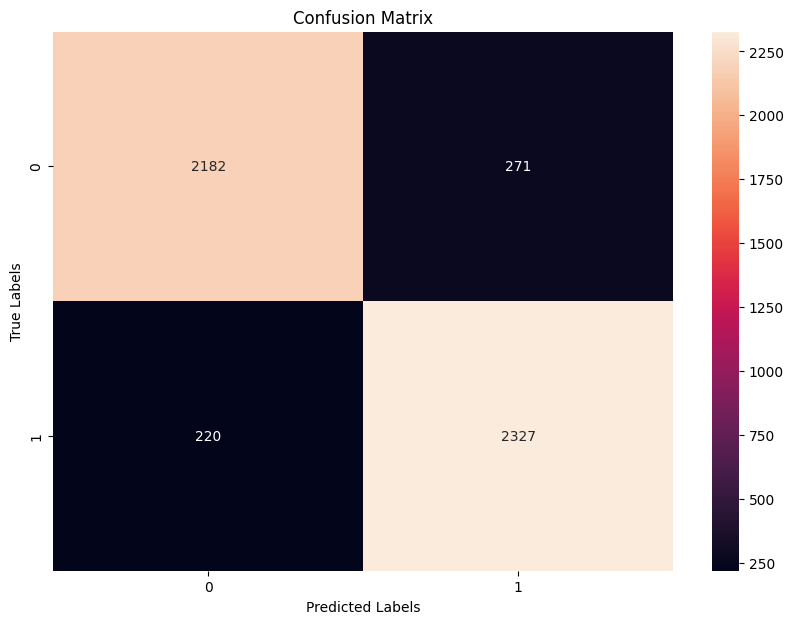

In [25]:

# Import the required libraries for generating a confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
confusion_matrix_result = confusion_matrix(y_test, prediction_y)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix_result, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### Analysis of the Confusion Matrix: 
The confusion matrix shows a relatively balanced number of false positives and false negatives, which is a positive sign that the model doesn't have a strong bias towards one class over the other.

In [26]:
# Calculate the precision score for the positive class
precision = precision_score(y_test, prediction_y, pos_label='pos')

# Compute the recall score for the positive class
recall = recall_score(y_test, prediction_y, pos_label='pos')

# Calculate the F2 score using precision and recall
f2_score = fbeta_score(y_test, prediction_y,beta=2, pos_label='pos')


In [27]:
print("===Support Vector Machine Evaluation Metrics===")
print('The porcentage of the Recall is : {:.2f}%'.format(recall * 100))
print('The porcentage of the Precision is :{:.2f}%'.format(precision * 100))
print('The porcentage of the F2-Score is : {:.2f}%'.format(f2_score * 100))

===Support Vector Machine Evaluation Metrics===
The porcentage of the Recall is : 91.36%
The porcentage of the Precision is :89.57%
The porcentage of the F2-Score is : 91.00%


## Conclusion

### Model Performance:
 With an accuracy of 89%, the model demonstrates a high level of correctness in its predictions, which is commendable for a text classification task. The precision of 87.9% means that when the model predicts a particular class, it is correct around 88% of the time. A recall of 90.6% indicates that the model is able to identify 90.6% of all relevant instances correctly. The F2-score, which balances precision and recall and gives more weight to recall, is at 90.1%, suggesting a good balance particularly when missing a positive instance is costly.

### Model Strengths:
The high values across all metrics suggest that the feature extraction and the model's learning algorithm have effectively captured the patterns in the dataset. The model appears to generalize well and makes predictions with good confidence.

### Areas for Improvement:
There is always room for improvement, even with a good model. Given that precision is slightly lower than recall, efforts could be made to reduce the false positive rate, perhaps by further tuning the model's decision threshold or by enhancing feature selection. Investigating the false positives and false negatives in more detail could provide insights into specific areas where the model may be struggling.

### Practical Implications: 
The robust performance of the model suggests it could be a valuable tool in practical applications. However, the specific use case dictates the acceptability of the error rates. For example, in sensitive areas such as healthcare or finance, even a small percentage of errors could have significant consequences, and further improvements might be necessary.

### Next Steps:
To improve the model, consider experimenting with different classification algorithms, feature selection methods, or even ensemble techniques to boost performance. Additionally, exploring more complex NLP features like word embeddings or context-aware models could provide performance gains.



In conclusion, the text classifier model exhibits strong performance, indicating it's a well-constructed model suitable for the task at hand. While it shows good predictive power, like all models, it is not perfect and there is potential to enhance its precision and reduce error rates through further refinement and testing.